Submitted by:  Tiffany Wilson

### Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [1]:
import pandas as pd 
import numpy as np
import sklearn as sk 
import psycopg2 as psy

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot') 
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import normaltest
from sklearn.preprocessing import Imputer

#### Step 2: Examine your data 

In [2]:
# STARTER CODE
# df_raw = pd.read_csv("airport_cancellations.csv")
# df = df_raw.dropna() 
# print df.head()

** Hey - guess what? **  I did this part a bit differently!  I loaded the CSV files into Excel, examined and cleaned the data there.  Then I loaded the clean data into a local Postgres database.  You can read all about what I did in my accompaying report (see link to report on Github Readme).

### Intro: Write a problem statement / aim for this project

Please see my report at https://docs.google.com/document/d/1KOwCaFqv0lXzz7NAQZfL2-JWt1t73x9SrruswjnkxRw/edit?usp=sharing

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [3]:
# STARTER CODE
# I used PGAdmin to create this database.
# postgres -D /usr/local/pgsql/data >logfile 2>&1 
# createdb mydb

Using PGAdmin, I created the ** mydb ** Postgres database to house the data for this study.  Here is the information on this new database:

** User: **  dsi_student
** Password: **  gastudents
** Host: **  localhost
** Dbname: ** mydb
** Port: **  5432

In [4]:
# Local Postgres database - used initially as I created my database, and used it for testing.
# conn = psy.connect('host=localhost dbname=mydb user=dsi_student password=gastudents port=5432')

# Hosted Postgres database on ASW's RDS.
conn = psy.connect('host=dsi-tdw-pgdb.cjnvgk0tjuxx.us-west-1.rds.amazonaws.com dbname=mydb user=dsi_student \
password=gastudents port=5432')
#NOTE: If the AWS RDS connection doesn't connect, let me know as security settings may need to be reset on RDS.

Join airport_cancellations.csv and airports.csv into one table

In [5]:
# Well, I have different plans!  :)
# I loaded all of the data into tables in the Postgres database, so I'll get the joined results using an SQL query.

Query the database for our intial data

In [6]:
# STARTER CODE
# cur = conn.cursor()
# cur.execute("""SELECT * FROM mydb""")
# ap = cur.fetchall()
# print ap

sql = 'select airports.*,\
 ac.year,\
 ac.departure_cancellations,\
 ac.arrival_cancellations,\
 ac.departure_diversions,\
 ac.arrival_diversions\
 from airport_cancellations as ac \
 left join airports \
 on ac.airport_code = airports.airport_code;'
dfResults = pd.read_sql(sql, con=conn)

In [7]:
dfResults.head()

,key,airport_code,name,alias,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_avail,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
0,2348,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.0402,-106.609,Yes,2004,242,235,71,46
1,2348,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.0402,-106.609,Yes,2005,221,190,61,33
2,2348,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.0402,-106.609,Yes,2006,392,329,71,124
3,2348,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.0402,-106.609,Yes,2007,366,304,107,45
4,2348,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.0402,-106.609,Yes,2008,333,300,79,42


#### 1.2 What are the risks and assumptions of our data? 

*** 1 *** We assume that the data provided contains a complete set of metrics for the years 2004 - 2014, for a handful of airports.

*** 2 *** We assume that the data provided is correct and comprehensive.

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [8]:
dfResults.describe()

,key,latitude,longitude,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
count,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000
mean,1706.408696,36.447421,-95.079997,2008.986335,1292.038509,1333.124224,173.315528,169.413665
std,1005.635275,6.665114,20.673705,3.158116,1835.961943,1975.224868,172.345539,228.521615
min,246.000000,18.439300,-157.922000,2004.000000,0.000000,0.000000,0.000000,0.000000
25%,769.000000,32.896800,-112.012000,2006.000000,349.000000,314.000000,62.000000,41.000000
50%,1531.000000,37.619000,-87.897100,2009.000000,663.000000,642.000000,110.000000,84.000000
75%,2502.000000,40.795200,-80.152700,2012.000000,1472.000000,1523.000000,236.000000,190.000000
max,3575.000000,61.174100,-66.002000,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000


## In our join of the airport_cancellations and airports tables, we only have a few numeric columns:

** key: **  this is part of the primary key for the airport.  This is unique for the airport.

** latitude: **  the latitudinal value for the airport's location.  This is unique for the airport.

** longitude: **  the longitudinal value for the airport's location.  This is unique for the airport.

** departure_cancellations: **  average number of departure cancellations in a year.

** arrival_cancellations: **  average number of arrival cancellations in a year.

** departure_diversions: **  average number of departure diversions in a year.

** arrival_diversions: **  average number of arrive diversions in a year.

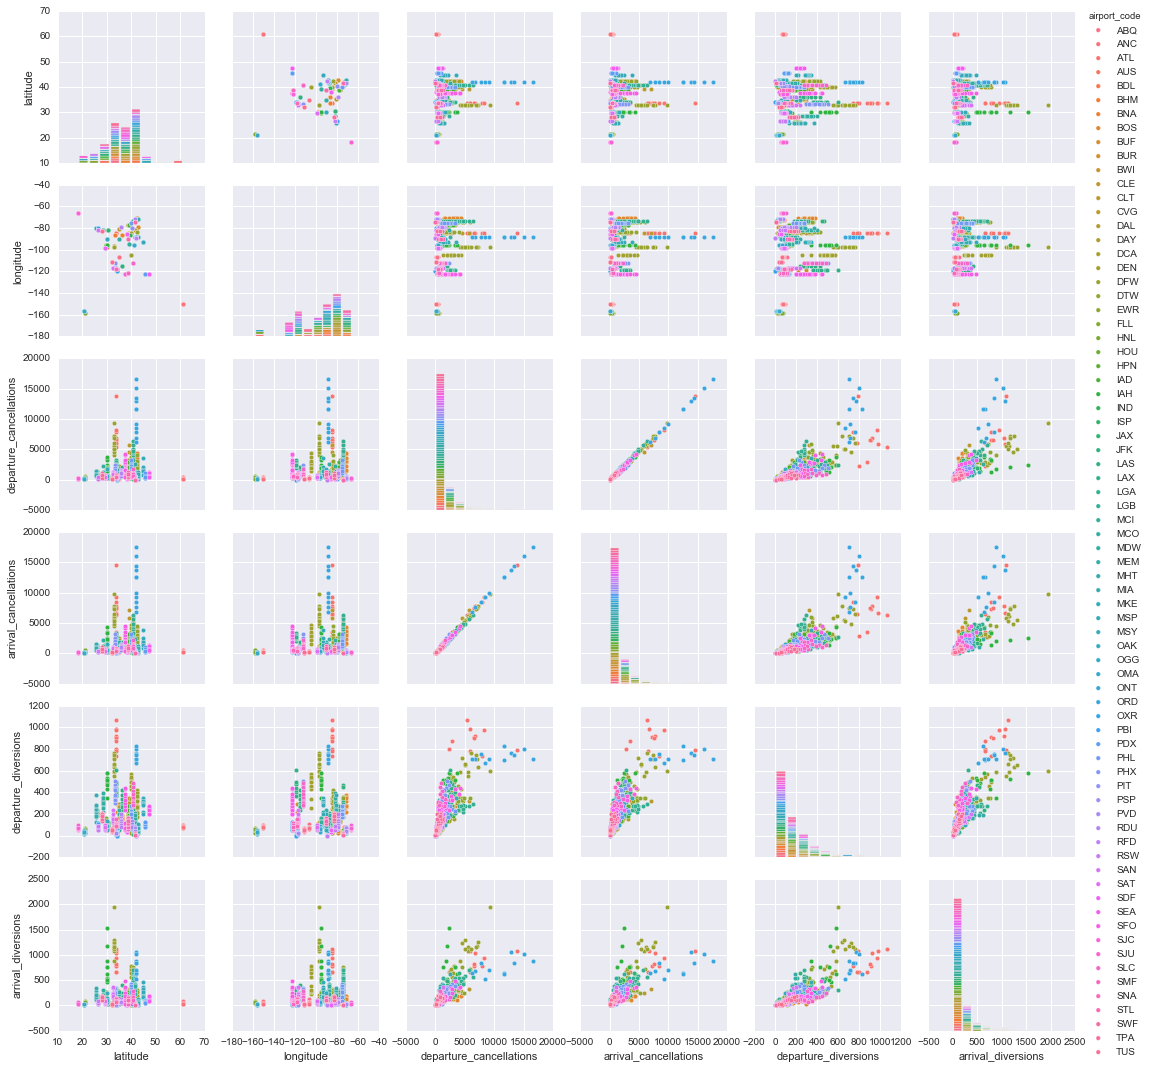

In [9]:
# Choose which columns to plot
plotCols = ["airport_code","latitude","longitude","departure_cancellations","arrival_cancellations",\
            "departure_diversions","arrival_diversions"]
sns.set()
sns.pairplot(dfResults.ix[:,plotCols], hue="airport_code")

#### Are there any unique values? 

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

#### 3.2 Format and Clean the Data

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

In [11]:
statList, pvalueList = normaltest(dfResults['departure_cancellations'], axis=0, nan_policy='propagate')
print statList
print pvalueList
# Didn't have time to complete.

684.127846768
2.77667861878e-149


#### 4.2 Find correlations in the data

It appears that there are numerous positive, linear correlations among the metrics in airport_cancellations.

#### 4.3 What is the value of understanding correlations before PCA? 

** Answer: ** They may provide insights into components revealed through PCA.

#### 4.4 Validate your findings using statistical analysis

#### 4.5 How can you improve your overall analysis? 

Answer: 

### Part 5: Perform a PCA and Present Findings

#### 5.1 Conduct the PCA

## PCA #1

In [12]:
# Create a clean data frame 
pcaCols = ['key','year','departure_cancellations','arrival_cancellations']
ap1 = dfResults[pcaCols]
print ap1.head()

    key  year  departure_cancellations  arrival_cancellations
0  2348  2004                      242                    235
1  2348  2005                      221                    190
2  2348  2006                      392                    329
3  2348  2007                      366                    304
4  2348  2008                      333                    300


In [13]:
# Scale the data
Xmatrix = ap1.as_matrix()
scaler = StandardScaler(copy=False)
scaler.fit_transform(Xmatrix)

/Users/tiffanydwilson/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tiffanydwilson/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.63839266, -1.57987742, -0.57228382, -0.5562946 ],
       [ 0.63839266, -1.26303603, -0.58372908, -0.57909098],
       [ 0.63839266, -0.94619465, -0.49053199, -0.50867549],
       ..., 
       [-1.22626454,  0.95485367, -0.64041035, -0.62113763],
       [-1.22626454,  1.27169505, -0.60879964, -0.59783467],
       [-1.22626454,  1.58853644, -0.6071646 , -0.5968215 ]])

In [14]:
Xmatrix.shape

(805, 4)

In [15]:
# Run the PCA
nComps = 4
pca = PCA(n_components = nComps)
Y = pca.fit_transform(Xmatrix)

In [16]:
Y.shape

(805, 4)

In [17]:
# Let's review the 'eigen values' for each component.
print pca.explained_variance_ratio_
print pca.explained_variance_
pca_loadings = pd.DataFrame(pca.components_.T, columns=pcaCols )
print pca_loadings

[  8.76819655e-01   1.22080110e-01   1.09904030e-03   1.19552482e-06]
[  7.25418473e+06   1.01000435e+06   9.09268092e+03   9.89092555e+00]
        key      year  departure_cancellations  arrival_cancellations
0  0.003849  0.999967                -0.007127               0.000030
1 -0.000079  0.000019                -0.001645              -0.999999
2  0.680744  0.002600                 0.732515              -0.001259
3  0.732511 -0.007671                -0.680711               0.001061


In [18]:
# Sum of squares for each row
for i in range(0,pca_loadings.shape[0]):
    print 'Sum of Squares for Row ' + str(i)+": " + str(np.sum(np.square(pca_loadings.ix[i,:])))

# Sum of squares for each columns
for i in range(0,pca_loadings.shape[1]):
    print 'Sum of Squares for Column ' + str(i)+": " + str(np.sum(np.square(pca_loadings.ix[:,i])))

Sum of Squares for Row 0: 1.0
Sum of Squares for Row 1: 1.0
Sum of Squares for Row 2: 1.0
Sum of Squares for Row 3: 1.0
Sum of Squares for Column 0: 1.0
Sum of Squares for Column 1: 1.0
Sum of Squares for Column 2: 1.0
Sum of Squares for Column 3: 1.0


[  87.68196546   99.88997642   99.99988045  100.        ]


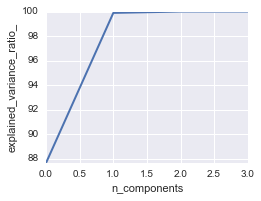

In [19]:
# Plot the scree plot
tot = sum(pca.explained_variance_ratio_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_ratio_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
# plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.plot(cum_var_exp, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
print cum_var_exp

In [20]:
# Let's review the values of each component
cols = ['PC'+str(x) for x in range(1,len(pcaCols) + 1)]
ap_pca = pd.DataFrame(Y, columns=cols)
ap_pca.sort_values(by='PC1', ascending=False).head(10)

,PC1,PC2,PC3,PC4
531,22325.395954,-627.104182,177.065858,-0.083907
532,20176.070033,-619.850957,33.890708,-0.678174
23,18167.119327,-853.615739,245.754368,2.128024
538,17815.765017,-610.660559,48.543254,-6.515269
530,17048.160949,-607.866081,26.079707,1.582499
528,15337.819357,-601.532471,-9.016108,3.775726
535,15230.626245,-601.051899,0.486825,-3.231418
537,11698.427377,-588.423169,-135.360256,-4.728171
201,11683.851546,1399.855590,167.376300,0.812587
529,10643.386389,-584.077896,-95.481155,3.289853


## PCA #2

In [23]:
# PCA #2
# Create a clean data frame
pcaCols = ['departure_cancellations','arrival_cancellations','departure_diversions','arrival_diversions']
ap1 = dfResults[pcaCols]
print ap1.head()

   departure_cancellations  arrival_cancellations  departure_diversions  \
0                      242                    235                    71   
1                      221                    190                    61   
2                      392                    329                    71   
3                      366                    304                   107   
4                      333                    300                    79   

   arrival_diversions  
0                  46  
1                  33  
2                 124  
3                  45  
4                  42  


In [24]:
# Scale the data
Xmatrix = ap1.as_matrix()
scaler = StandardScaler(copy=False)
scaler.fit_transform(Xmatrix)

/Users/tiffanydwilson/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tiffanydwilson/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.57228382, -0.5562946 , -0.59403416, -0.54038823],
       [-0.58372908, -0.57909098, -0.6520932 , -0.59731099],
       [-0.49053199, -0.50867549, -0.59403416, -0.19885164],
       ..., 
       [-0.64041035, -0.62113763, -0.785629  , -0.61482569],
       [-0.60879964, -0.59783467, -0.6462873 , -0.66299111],
       [-0.6071646 , -0.5968215 , -0.68692863, -0.57103895]])

In [25]:
# Run the PCA
nComps = 4
pca = PCA(n_components = nComps)
Y = pca.fit_transform(Xmatrix)
Y.shape

(805, 4)

In [26]:
# Let's review the eigen values for each component.
print 'Explained Variance ratio: ' + str(pca.explained_variance_ratio_)
print 'Explained Variance: '+ str(pca.explained_variance_)
sum_evr = np.sum(pca.explained_variance_ratio_)
evrPct = [x/sum_evr*100.0 for x in pca.explained_variance_ratio_]
print 'Explained Variance ratio %: '+ str(evrPct)
pca_loadings = pd.DataFrame(pca.components_.T, columns=pcaCols )
print pca_loadings

Explained Variance ratio: [  9.94744800e-01   3.28077845e-03   1.48127028e-03   4.93150771e-04]
Explained Variance: [  7.30645925e+06   2.40975113e+04   1.08800176e+04   3.62222151e+03]
Explained Variance ratio %: [99.474480049715069, 0.32807784487022101, 0.14812702832784005, 0.049315077086870752]
   departure_cancellations  arrival_cancellations  departure_diversions  \
0                 0.678271              -0.178694             -0.600164   
1                 0.729903               0.052446              0.567707   
2                 0.051567               0.519339              0.389731   
3                 0.067314               0.834029             -0.406966   

   arrival_diversions  
0           -0.384474  
1            0.377094  
2           -0.758774  
3            0.366391  


In [27]:
# Sum of squares for each row
for i in range(0,pca_loadings.shape[0]):
    print 'Sum of Squares for Row ' + str(i)+": " + str(np.sum(np.square(pca_loadings.ix[i,:])))

# Sum of squares for each columns
for i in range(0,pca_loadings.shape[1]):
    print 'Sum of Squares for Column ' + str(i)+": " + str(np.sum(np.square(pca_loadings.ix[:,i])))

Sum of Squares for Row 0: 1.0
Sum of Squares for Row 1: 1.0
Sum of Squares for Row 2: 1.0
Sum of Squares for Row 3: 1.0
Sum of Squares for Column 0: 1.0
Sum of Squares for Column 1: 1.0
Sum of Squares for Column 2: 1.0
Sum of Squares for Column 3: 1.0


[  99.47448005   99.80255789   99.95068492  100.        ]


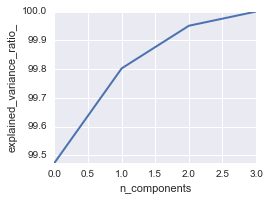

In [28]:
# Plot the scree plot
tot = sum(pca.explained_variance_ratio_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_ratio_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
# plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.plot(cum_var_exp, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
print cum_var_exp

In [29]:
# Let's review the values of each component
cols = ['PC'+str(x) for x in range(1,len(pcaCols) + 1)]
ap_pca = pd.DataFrame(Y, columns=cols)
ap_pca.sort_values(by='PC1', ascending=False).head(10)

,PC1,PC2,PC3,PC4
531,22323.050939,-1011.390438,-63.775764,88.732351
532,20195.726727,-643.079436,18.437653,114.590775
23,18197.921103,-472.480927,-195.698684,0.094190
538,17827.514488,-644.756594,44.659131,47.677318
530,17079.678668,-369.611674,-26.281650,113.154534
528,15344.146937,-601.820816,133.370515,5.257774
535,15241.821596,-554.493826,188.821175,-112.151360
201,11778.039689,703.471642,-618.865011,401.723928
537,11722.411370,-222.338764,189.790718,35.976071
529,10656.034474,-323.326095,209.720590,-37.390640


## Let's try some of the features in airport_operations.

In [30]:
# Join the airport_operations_metrics and airport_cancellations tables.
sql = 'select ao.*,\
 ac.* \
 from airport_cancellations as ac \
 left join airport_operations_metrics as ao \
 on ac.airport_code = ao.airport_code\
 and ac.year = ao.year;'
dfResults2 = pd.read_sql(sql, con=conn)

pcaCols = ['departures_metric','arrivals_metric','on_time_gate_departures_pct','on_time_airport_departures_pct',\
          'on_time_gate_arrivals_pct','gate_departure_delay_avg','taxi_out_time_avg','taxi_out_delay_avg',\
           'airport_departure_delay_avg','airborne_delay_avg','taxi_in_delay_avg','block_delay_avg',\
           'gate_arrival_delay_avg','departure_cancellations','arrival_cancellations','departure_diversions',\
          'arrival_diversions']
ap1 = dfResults2[pcaCols]
ap1.head()

,departures_metric,arrivals_metric,on_time_gate_departures_pct,on_time_airport_departures_pct,on_time_gate_arrivals_pct,gate_departure_delay_avg,taxi_out_time_avg,taxi_out_delay_avg,airport_departure_delay_avg,airborne_delay_avg,taxi_in_delay_avg,block_delay_avg,gate_arrival_delay_avg,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
0,53971.0,53818.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87,242,235,71,46
1,51829.0,51877.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24,221,190,61,33
2,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82,392,329,71,124
3,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71,366,304,107,45
4,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48,333,300,79,42


In [31]:
ap1.shape

(805, 17)

In [32]:
Xmatrix = ap1.as_matrix()

# Replace null values with mean value.
imp = Imputer(copy=False)
imp.fit_transform(Xmatrix)

# Scale the data
scaler = StandardScaler(copy=False)
scaler.fit_transform(Xmatrix)

Xmatrix

array([[ -6.09437967e-01,  -6.08410964e-01,   4.58726368e-01, ...,
         -5.56294598e-01,  -5.94034158e-01,  -5.40388228e-01],
       [ -6.31377525e-01,  -6.28363765e-01,   6.70057072e-01, ...,
         -5.79090978e-01,  -6.52093200e-01,  -5.97310993e-01],
       [ -6.53368295e-01,  -6.35333368e-01,   3.68430521e-01, ...,
         -5.08675494e-01,  -5.94034158e-01,  -1.98851641e-01],
       ..., 
       [  0.00000000e+00,  -1.49588598e-16,  -4.26589480e-15, ...,
         -6.09992738e-01,  -9.30776604e-01,  -5.79796296e-01],
       [  0.00000000e+00,  -1.49588598e-16,  -4.26589480e-15, ...,
         -4.34207320e-01,  -5.65004637e-01,  -5.00980161e-01],
       [  0.00000000e+00,  -1.49588598e-16,  -4.26589480e-15, ...,
         -5.88209530e-01,  -8.43688040e-01,  -4.48436070e-01]])

In [33]:
# Run the PCA
nComps = len(pcaCols)
pca = PCA(n_components = nComps)
Y = pca.fit_transform(Xmatrix)

In [34]:
# Let's review the eigen values for each component.
print 'Explained Variance ratio: ' + str(pca.explained_variance_ratio_)
print 'Explained Variance: '+ str(pca.explained_variance_)
sum_evr = np.sum(pca.explained_variance_ratio_)
evrPct = [x/sum_evr*100.0 for x in pca.explained_variance_ratio_]
print 'Explained Variance ratio %: '+ str(evrPct)
pca_loadings = pd.DataFrame(pca.components_.T, columns=pcaCols )

Explained Variance ratio: [  5.38923354e-01   2.44504599e-01   7.15276925e-02   3.82217508e-02
   2.99925458e-02   2.47118333e-02   1.45444744e-02   1.11624073e-02
   9.75470135e-03   8.42075350e-03   3.66344789e-03   3.24475245e-03
   8.79241216e-04   2.85945986e-04   9.61113248e-05   5.63141717e-05
   1.00751936e-05]
Explained Variance: [  9.16169701e+00   4.15657818e+00   1.21597077e+00   6.49769764e-01
   5.09873278e-01   4.20101166e-01   2.47256065e-01   1.89760925e-01
   1.65829923e-01   1.43152810e-01   6.22786142e-02   5.51607917e-02
   1.49471007e-02   4.86108176e-03   1.63389252e-03   9.57340919e-04
   1.71278291e-04]
Explained Variance ratio %: [53.892335367298742, 24.450459903721715, 7.1527692516717121, 3.8221750818618601, 2.9992545770777923, 2.4711833314532741, 1.4544474441092021, 1.1162407333470068, 0.97547013549551653, 0.84207535021116431, 0.36634478939445125, 0.32447524517453824, 0.087924121579099734, 0.028594598592267272, 0.00961113248294998, 0.0056314171727752148, 0.0

In [35]:
pca_loadings

,departures_metric,arrivals_metric,on_time_gate_departures_pct,on_time_airport_departures_pct,on_time_gate_arrivals_pct,gate_departure_delay_avg,taxi_out_time_avg,taxi_out_delay_avg,airport_departure_delay_avg,airborne_delay_avg,taxi_in_delay_avg,block_delay_avg,gate_arrival_delay_avg,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
0,0.258788,0.271983,-0.079480,-0.095673,0.003239,-0.257352,-0.314548,0.121699,-0.097248,-0.009851,-0.191835,0.336598,-0.021679,0.004046,-0.011433,0.020085,-0.709167
1,0.258498,0.272596,-0.081531,-0.097207,0.001270,-0.253405,-0.312064,0.123946,-0.097430,-0.019202,-0.197929,0.345238,-0.026679,0.025542,0.005718,-0.023391,0.704018
2,-0.164129,0.350266,0.329806,0.269173,0.005889,0.282322,-0.025372,0.287693,0.098987,0.196260,0.188083,0.241754,-0.160668,-0.567086,0.059598,0.113093,0.010849
3,-0.272609,0.229805,-0.002621,0.291892,-0.134633,0.011993,-0.040514,0.241786,0.142037,0.334843,-0.052348,-0.038333,-0.341216,0.645692,-0.100860,-0.170581,-0.013187
4,-0.147651,0.400930,0.088831,-0.295010,0.023403,-0.024482,0.035085,-0.328942,-0.111485,0.484151,0.277616,0.040076,0.518069,0.133950,-0.000606,0.009231,0.004395
5,0.200665,-0.341398,-0.257138,-0.153058,0.009344,-0.041450,-0.061984,0.014146,0.019652,0.565975,0.154835,0.023365,-0.318432,-0.045815,-0.038382,0.545109,0.020944
6,0.269451,0.040292,0.414422,-0.073588,0.297991,0.222666,-0.174546,0.041258,-0.130966,0.264958,-0.505683,-0.484342,0.003758,-0.012258,0.008858,-0.012523,0.002817
7,0.275467,0.019427,0.395937,-0.119593,0.217907,0.347868,0.067297,-0.043259,-0.077819,-0.314453,0.307654,0.284534,-0.126292,0.438845,-0.097512,0.281401,-0.000010
8,0.279472,-0.235781,0.006012,-0.185771,0.107440,0.141741,-0.001881,-0.014908,-0.024152,0.247729,0.272038,0.178620,-0.212057,-0.087672,0.032071,-0.760183,-0.021728
9,0.201488,-0.054774,0.484685,-0.297320,-0.646819,-0.290990,0.180155,0.165798,0.241993,0.015503,0.027991,-0.101277,-0.011546,-0.008525,0.001857,0.006023,0.000902


[  53.89233537   78.34279527   85.49556452   89.3177396    92.31699418
   94.78817751   96.24262496   97.35886569   98.33433583   99.17641118
   99.54275597   99.86723121   99.95515533   99.98374993   99.99336106
   99.99899248  100.        ]


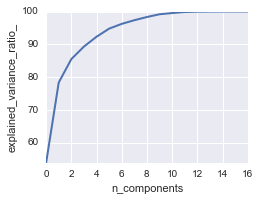

In [36]:
# Plot the scree plot
tot = sum(pca.explained_variance_ratio_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_ratio_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
# plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.plot(cum_var_exp, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
print cum_var_exp

In [37]:
# Let's review the values of each component
cols = ['PC'+str(x) for x in range(1,len(pcaCols) + 1)]
ap_pca = pd.DataFrame(Y, columns=cols)
ap_pca.sort_values(by='PC1', ascending=False).head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
531,12.871459,2.378838,-4.476349,2.169961,-4.130617,3.226790,-1.328352,-1.831345,-0.167391,0.261210,-0.113566,-0.036171,-0.053014,0.066113,0.009692,0.011673,-0.002420
333,12.605111,-4.687399,4.489221,-0.499027,2.133502,1.698456,0.772668,-0.884088,0.050077,0.488803,0.195096,0.395450,-0.410296,0.417932,-0.119222,-0.249244,0.001261
532,12.087595,2.861514,-4.259258,2.129040,-3.618735,2.658255,-0.535200,-1.044342,-0.181902,0.433027,0.113226,-0.354047,0.005517,0.093353,-0.040844,-0.012648,0.002592
538,11.947146,2.778613,-4.553293,1.691454,-1.653527,1.278512,-0.526626,-1.896965,2.629450,0.159676,0.076410,-0.351296,0.025659,-0.124824,0.033258,-0.035055,0.012975
530,11.611568,2.558947,-3.653424,1.686413,-2.663147,1.908895,-0.537777,-0.684563,-1.134992,0.346334,-0.059309,0.247349,-0.027519,0.066009,-0.043444,0.007216,0.010454
223,11.318301,-4.002695,2.184370,0.975347,0.451720,2.153748,0.619391,-0.055301,-0.677460,0.100774,0.358668,0.488979,0.285226,0.156584,-0.021699,-0.099029,-0.008734
528,10.908175,2.654771,-2.478873,1.452729,-1.640944,1.604246,-1.886845,-1.374407,-0.505741,-0.260034,0.210440,0.545615,-0.100064,0.118065,-0.043740,-0.016514,0.002229
366,10.721315,-3.774769,2.923725,0.591091,-0.804331,1.922132,0.540910,-0.470942,-0.330581,-0.612194,0.346292,0.287773,-0.060314,-0.113898,0.087136,-0.035428,0.006152
23,10.600191,4.566704,-3.391318,1.183154,-3.544578,2.115740,-0.354452,-0.654354,-0.875279,-0.459690,-0.421298,-0.044876,-0.168868,-0.087568,0.106145,0.005646,-0.036565
222,10.368440,-3.025415,3.458353,0.966788,0.468881,1.278032,1.026040,-0.024409,-1.001667,-0.338334,0.196353,0.399987,0.211862,0.099145,-0.047436,-0.015816,-0.006021


In [41]:
# Let's take a look at the rows that have the greatest impact on PC1.
dfResults2.ix[[531,333,532,538,530,223,528,366,23,222],:]

,airport_code,year,departures_metric,arrivals_metric,on_time_gate_departures_pct,on_time_airport_departures_pct,on_time_gate_arrivals_pct,gate_departure_delay_avg,taxi_out_time_avg,taxi_out_delay_avg,...,airborne_delay_avg,taxi_in_delay_avg,block_delay_avg,gate_arrival_delay_avg,airport_code,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
531,ORD,2007.0,455562.0,455118.0,0.6854,0.5769,0.6909,20.81,19.02,7.63,...,3.81,3.22,5.73,22.44,ORD,2007,16618,17571,707,887
333,JFK,2007.0,210060.0,209898.0,0.6688,0.3808,0.6298,22.68,35.76,18.94,...,6.63,4.01,7.21,24.92,JFK,2007,4102,4089,236,635
532,ORD,2008.0,431539.0,431421.0,0.7049,0.6115,0.7062,19.94,18.67,7.04,...,3.90,3.34,5.44,21.90,ORD,2008,15050,16094,801,1027
538,ORD,2014.0,430429.0,430750.0,0.6787,0.5784,0.7050,20.21,17.50,6.17,...,3.47,6.18,5.05,20.09,ORD,2014,13454,14355,739,831
530,ORD,2006.0,466079.0,467039.0,0.7036,0.5881,0.7100,19.66,19.33,7.75,...,3.56,2.82,5.59,21.15,ORD,2006,12915,13808,766,1063
223,EWR,2007.0,209019.0,207435.0,0.6903,0.4335,0.6180,21.24,28.74,15.22,...,5.49,2.80,6.89,27.78,EWR,2007,5926,5992,345,718
528,ORD,2004.0,485187.0,484859.0,0.7179,0.5739,0.7210,17.79,20.23,9.36,...,3.19,3.34,5.81,19.19,ORD,2004,11725,12579,700,648
366,LGA,2007.0,191343.0,191847.0,0.7004,0.4267,0.6109,19.48,27.32,15.00,...,6.93,2.56,6.84,25.00,LGA,2007,6415,6304,290,573
23,ATL,2005.0,484570.0,480171.0,0.7413,0.6216,0.7337,15.50,18.52,7.26,...,4.24,2.72,4.62,17.23,ATL,2005,13837,14480,790,1080
222,EWR,2006.0,214805.0,213118.0,0.7189,0.4525,0.6383,18.07,29.13,15.42,...,6.21,2.65,7.25,24.79,EWR,2006,4557,4650,346,756


## Let's explore some of the data, with guidance from our PCA results.

In [42]:
# Let's take a look at the features for Chicago O'Hare.
sql = 'select ao.*,\
 ac.* \
 from airport_cancellations as ac \
 left join airport_operations_metrics as ao \
 on ac.airport_code = ao.airport_code\
 and ac.year = ao.year \
 where ac.airport_code = \'ORD\';'
dfAirportMetrics = pd.read_sql(sql, con=conn)
dfAirportMetrics

,airport_code,year,departures_metric,arrivals_metric,on_time_gate_departures_pct,on_time_airport_departures_pct,on_time_gate_arrivals_pct,gate_departure_delay_avg,taxi_out_time_avg,taxi_out_delay_avg,...,airborne_delay_avg,taxi_in_delay_avg,block_delay_avg,gate_arrival_delay_avg,airport_code,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
0,ORD,2004,485187,484859,0.7179,0.5739,0.7210,17.79,20.23,9.36,...,3.19,3.34,5.81,19.19,ORD,2004,11725,12579,700,648
1,ORD,2005,473216,474168,0.7242,0.6108,0.7672,16.76,19.03,7.45,...,3.05,3.15,4.11,15.45,ORD,2005,8466,9199,665,518
2,ORD,2006,466079,467039,0.7036,0.5881,0.7100,19.66,19.33,7.75,...,3.56,2.82,5.59,21.15,ORD,2006,12915,13808,766,1063
3,ORD,2007,455562,455118,0.6854,0.5769,0.6909,20.81,19.02,7.63,...,3.81,3.22,5.73,22.44,ORD,2007,16618,17571,707,887
4,ORD,2008,431539,431421,0.7049,0.6115,0.7062,19.94,18.67,7.04,...,3.90,3.34,5.44,21.90,ORD,2008,15050,16094,801,1027
5,ORD,2009,404978,404952,0.7916,0.7251,0.8063,13.25,16.78,5.13,...,3.65,3.84,3.60,13.39,ORD,2009,6827,7679,710,677
6,ORD,2010,430948,430618,0.7803,0.7090,0.7938,14.09,16.26,5.05,...,2.48,3.31,3.54,14.33,ORD,2010,7786,8443,755,845
7,ORD,2011,429476,428779,0.7605,0.6827,0.7772,15.61,16.55,5.60,...,2.16,3.18,3.59,16.03,ORD,2011,11659,12494,830,615
8,ORD,2012,427374,427768,0.7707,0.6981,0.8069,14.45,16.06,4.97,...,1.89,3.16,2.74,13.31,ORD,2012,6157,6814,703,640
9,ORD,2013,425352,428767,0.7094,0.6275,0.7521,18.64,16.60,5.46,...,2.26,3.98,3.71,17.51,ORD,2013,9155,9999,709,709


#### 5.2 Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps

Please see my report at https://docs.google.com/document/d/1KOwCaFqv0lXzz7NAQZfL2-JWt1t73x9SrruswjnkxRw/edit?usp=sharing

### Part 6: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

Find out more about these steps at https://docs.google.com/document/d/1KOwCaFqv0lXzz7NAQZfL2-JWt1t73x9SrruswjnkxRw/edit?usp=sharing

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied